In [37]:
import numpy as np
import random
from random import sample
import scipy as sp
from scipy.stats import qmc
import matplotlib.pyplot as plt

In [38]:
def mandelbrot(c,max_iters):
    counter=0
    threshold=2
    Z_now=complex(0,0)
    while(counter<max_iters):
        Z_next=pow(Z_now,2)+c
        if(abs(Z_next)>threshold):
            return counter
        Z_now=Z_next
        counter+=1
    return max_iters

In [39]:
def point_counter(x,y,max_iters):
    '''
    Function to count number of points in the Mandelbrot Set
    '''
    counter=0
    for i,x_i in enumerate(x):
        c=complex(x_i,y[i])
        check=mandelbrot(c,max_iters)
        if check==max_iters : counter+=1
    return counter


In [40]:
def PR_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Monte Carlo method
    '''
    x_samples = np.random.uniform(x_range[0], x_range[1], num_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], num_samples)
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    return estimated_area

In [41]:
def LHS_area_estimate(x_range, y_range, max_iters, num_samples):
    '''
    Estimates area of Mandelbrot set using Latin Hypercube methhod
    '''
    sample_set = qmc.LatinHypercube(d=2)
    sample = sample_set.random(n=num_samples)
    x_samples = x_range[0] + sample[:, 0] * (x_range[1] - x_range[0])
    y_samples = y_range[0] + sample[:, 1] * (y_range[1] - y_range[0])
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    
    return estimated_area

In [42]:
def ortho_area_estimate(x_range, y_range, max_iters, num_samples, sub_sections): 

    samples_per_section = num_samples // (sub_sections * sub_sections)

    x_size = np.linspace(x_range[0], x_range[1], sub_sections + 1)
    y_size = np.linspace(y_range[0], y_range[1], sub_sections + 1)

    x_samples = []
    y_samples = []

    for i in range(sub_sections):
        for j in range(sub_sections):

            # Latin hypercube for each sub section
            sample_set = qmc.LatinHypercube(d=2)
            cell_samples = sample_set.random(n=samples_per_section)

            #Min and max of y values
            x_cell_min, x_cell_max = x_size[i], x_size[i + 1]
            y_cell_min, y_cell_max = y_size[j], y_size[j + 1]

            # Scales samples to be between 0 and 1 for LHS
            x_cell_samples = x_cell_min + cell_samples[:, 0] * (x_cell_max - x_cell_min)
            y_cell_samples = y_cell_min + cell_samples[:, 1] * (y_cell_max - y_cell_min)

            # Adds scaled points to sample arrays 
            x_samples.extend(x_cell_samples)
            y_samples.extend(y_cell_samples)

    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)

    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    
    return estimated_area


In [43]:
def create_grid(x,y,max_iters):
    X,Y=np.meshgrid(x,y)
    C=np.vectorize(complex)(X,Y) 
    Z=[]
    for row in C: 
        Z_row=[]  
        for c in row: 
            Z_row.append(mandelbrot(c,max_iters))
        Z.append(Z_row) 
    Z=np.array(Z)
    return Z


In [44]:
def plot_fractal(Z,x1,x2,y1,y2):
    plt.figure(figsize=(10,7))
    plt.imshow(Z,extent=(x1,x2,y1,y2),cmap='Blues_r',interpolation='bilinear')
    plt.colorbar(label='Iterations to escape')
    plt.title('Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.show()



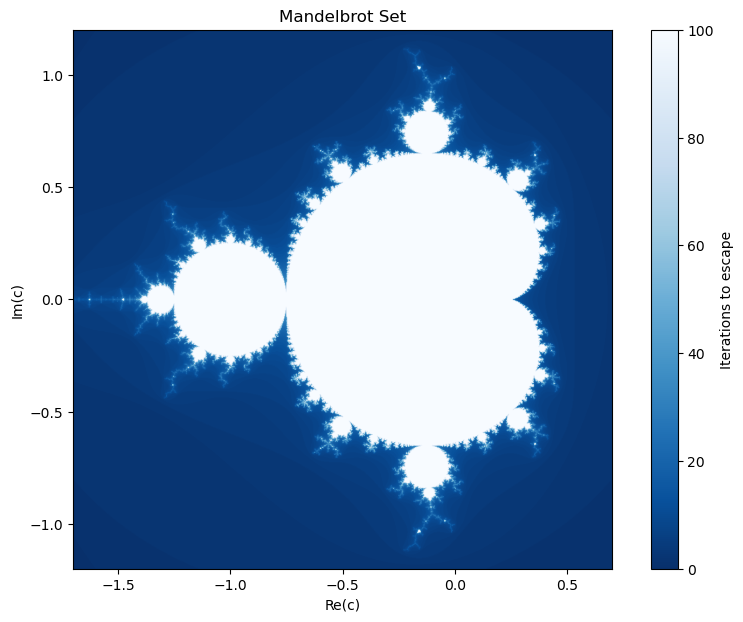

In [45]:
max_iters=100
n=1000
x=np.linspace(-1.7,0.7,n)  
y=np.linspace(-1.2,1.2,n)
plot_fractal(create_grid(x,y,max_iters),min(x),max(x),min(y),max(y))


In [69]:
def run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations):
    """
    Runs multiple simulations for the given max_iters, n (samples), and sample_type.
    Returns the average area estimate from the simulations.
    """
    areas = []
    
    for _ in range(num_simulations):
        if sample_type == "Pure Random":
            est_area = PR_area_estimate(x_range, y_range, max_iters, n)
        elif sample_type == "Latin Hypercube":
            est_area = LHS_area_estimate(x_range, y_range, max_iters, n)
        else:
            est_area = ortho_area_estimate(x_range, y_range, max_iters, n)

        areas.append(est_area)
    
    return np.mean(areas)


def plot_areas_convergence(x_range, y_range, n_list, max_iters_range, sample_type, num_simulations):
    """
    Plots the convergence of the area estimates with respect to increasing max_iters and n (samples).
    Runs multiple simulations for each combination of iterations and samples.
    """
    
    area_results = {} # Setting up library to save area results to find average area

    for n in n_list:  
        areas = []
        area_diffs = []
        
        for max_iters in max_iters_range: 
            # Run multiple simulations and average the results
            avg_area = run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations)
            areas.append(avg_area) 

        final_area = areas[-1]  # Last A{j,s} estimate for comparison
        print(final_area)

        # Calculate the difference from the final estimate for each iteration
        for area in areas[:-1]:
            diff = abs(area - final_area)
            area_diffs.append(diff)

        area_results[n] = area_diffs

    plt.figure(figsize=(10, 5))

    for n, diffs in area_results.items():
        plt.plot(range(len(diffs)), diffs, label=f"s = {n}")

    plt.title(f'Convergence of A(j,s) - A(i,s) for Mandelbrot Set')
    plt.xlabel("Iterations (j)")
    plt.ylabel("Difference A(j,s) - A(i,s)")
    plt.ylim(0, 2.0)
    plt.legend()
    plt.grid()
    plt.show()

0.96
1.76
1.408
1.472
1.368
1.5168
1.496
1.4664


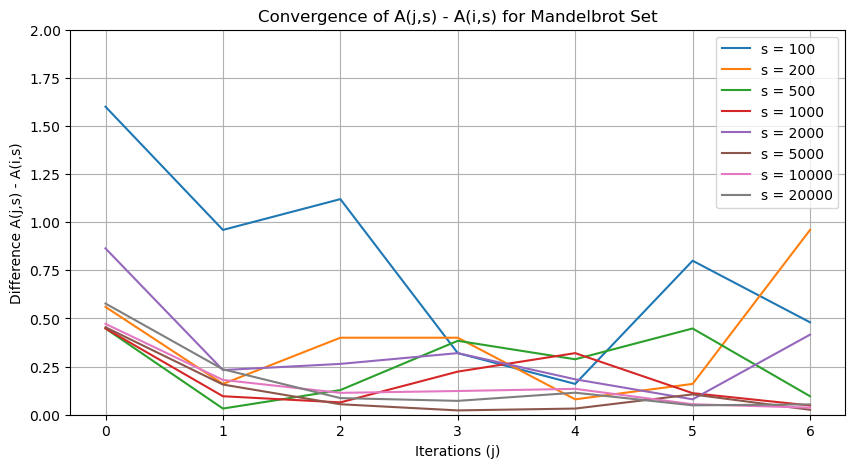

In [70]:
# Setting initial conditions 
x_range = (-2,2)
y_range = (-2,2)
max_iters_range = [10, 25, 50, 100, 200, 400, 800, 1000]
n_list = [100, 200, 500, 1000, 2000, 5000, 10000, 20000]
num_simulations = 1

plot_areas_convergence(x_range, y_range, n_list, max_iters_range, sample_type="Pure Random", num_simulations=1)

1.12
1.52
1.472
1.632
1.568
1.4112
1.5648
1.5


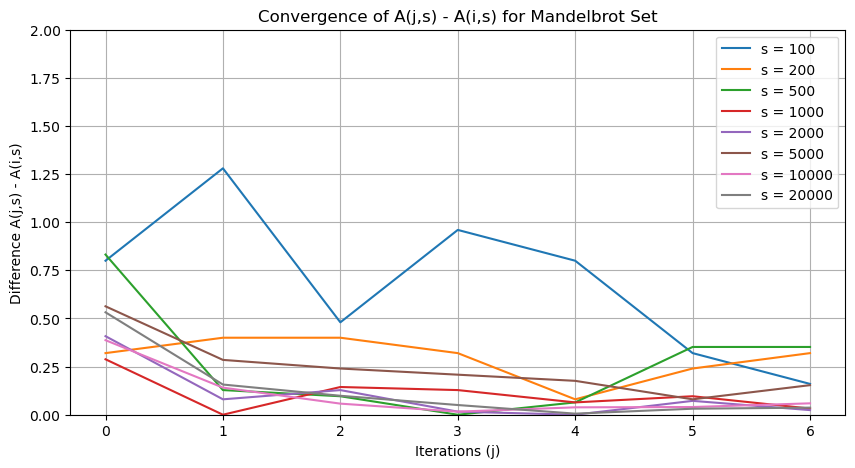

In [72]:
plot_areas_convergence(x_range, y_range, n_list, max_iters_range, sample_type="Latin Hypercube", num_simulations=1)

In [ ]:
plot_areas(x_range, y_range, n_list, max_iters_range, sample_type="Orthogonal", num_simulations=10)

TypeError: ortho_area_estimate() missing 1 required positional argument: 'sub_samples'